# Data and service model

In [1]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch 
import torchvision 
import torch.nn as nn 
import torch.optim as optim 
import numpy as np 
import os 
import os.path 
from torch.utils.data import DataLoader 
from tqdm.auto import tqdm 
from copy import deepcopy 
from resnet import ResNet18 
# Select device
print(torch.cuda.is_available()) 
device = torch.device('cuda')  
#加载mnist  
def get_trans():  
    # 设置一个转换的集合，先把数据转换到tensor，再归一化为均值.5，标准差.5的正态分布
    trans = torchvision.transforms.Compose( 
        [
            torchvision.transforms.ToTensor(),  # ToTensor方法把[0,255]变成[0,1]
            torchvision.transforms.Normalize( [0.5], [0.5] )
            # 变成mean(均值)=0，std（标准差standard deviation）=1的分布
        ]
    )
    return trans

DOWNLOAD_MNIST=True
train_set= torchvision.datasets.MNIST( root="./mnist",  # 设置数据集的根目录
    train=True,  # 是否是训练集
    transform=get_trans(),  # 对数据进行转换
    download=DOWNLOAD_MNIST
                                         )
val_set = torchvision.datasets.MNIST( root="./mnist", train=False,  # 测试集，所以false
    transform=get_trans(), download=DOWNLOAD_MNIST
                                      )
print(len(train_set))
print(len(val_set))

#指定训练集大小
train_size = 100
train_data = []
train_data_label = []
#每个类别取相同数量
for c in range(10):
    num = 0
    for i in range(50000):
        if train_set[i][1] == c:
            num+=1
            train_data.append(train_set[i][0].numpy())
            train_data_label.append(train_set[i][1])
            if num == train_size//10:
                break

train_data = torch.tensor(train_data)
train_data_label = torch.tensor(train_data_label)

train_dataset = TensorDataset(train_data,train_data_label)
print("训练集大小：",len(train_dataset))

#指定验证集大小 （同时作为解释器的验证集）
val_size = 100
val_data = []
val_data_label = []
#每个类别取相同数量
for c in range(10):
    num = 0
    for i in range(10000):
        if train_set[i+50000][1] == c:
            num+=1
            val_data.append(train_set[i+50000][0].numpy())
            val_data_label.append(train_set[i+50000][1])
            if num == val_size//10:
                break

val_data = torch.tensor(val_data)
val_data_label = torch.tensor(val_data_label)

val_dataset = TensorDataset(val_data,val_data_label)
print("验证集大小：",len(val_dataset))

#指定测试集大小（同时作为解释器的训练集）
test_size = 1000
test_data = []
test_data_label = []
#每个类别取相同数量
for c in range(10):
    num = 0
    for i in range(10000):
        if val_set[i][1] == c:
            num+=1
            test_data.append(val_set[i][0].numpy())
            test_data_label.append(val_set[i][1])
            if num == test_size//10:
                break

test_data = torch.tensor(test_data)
test_data_label = torch.tensor(test_data_label)

test_dataset = TensorDataset(test_data,test_data_label)
print("测试集大小：",len(test_dataset))


print("分类模型测试集大小",train_data.size(), train_data_label.size())
import torch.nn as nn
import torch
import time

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1=nn.Sequential(
            nn.Conv2d(          #(1,28,28)
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2   #padding=(kernelsize-stride)/2
            ),#(16,28,28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)#(16,14,14)
 
        )
        self.conv2=nn.Sequential(#(16,14,14)
            nn.Conv2d(16,32,5,1,2),#(32,14,14)
            nn.ReLU(),#(32,14,14)
            nn.MaxPool2d(2)#(32,7,7)
        )
        self.out=nn.Linear(32*7*7,10)
    def forward(self,x):
        x = self.conv1( x )
        x = self.conv2( x ) #(batch,32,7,7)
        x=x.view(x.size(0),-1) #(batch,32*7*7)
        output=self.out(x)
        return output
print("start")
EPOCH=50#总的训练次数
BATCH_SIZE=20#批次的大小
LR=0.0001#学习率#交叉熵损失函数不需要太大的学习率

train_loader=DataLoader(
                train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                )
val_loader=DataLoader(
            val_dataset, batch_size=BATCH_SIZE, shuffle=False,
            ) 
test_loader=DataLoader(
            test_dataset, batch_size=BATCH_SIZE, shuffle=False,
            ) 

grand_model_path = 'model/grand_mnist_{}_shuffle.pt'.format(train_size)
null_model_path = 'model/null_mnist_{}_shuffle.pt'.format(train_size)

if os.path.isfile(grand_model_path):
    print('Loading saved class model')
    #加载大模型和空模型
    grand_model = torch.load(grand_model_path).cuda()
    null_model = torch.load(null_model_path).cuda()

else:
    #训练过程
    cnn=CNN().cuda()
    null_model = cnn
    torch.save(null_model, null_model_path)
    optimizer=torch.optim.Adam(cnn.parameters(),lr=LR)
    loss_function=nn.CrossEntropyLoss()

    for ep in range(EPOCH):
        # 记录把所有数据集训练+测试一遍需要多长时间
        startTick =  time.perf_counter()
        for img, label in train_loader:  # 对于训练集的每一个batch
            # print(img,label)  
            img = img.cuda()
            label = label.cuda()

            out = cnn( img )  # 送进网络进行输出
            loss = loss_function( out, label )  # 获得损失
            # print(loss)
            optimizer.zero_grad()  # 梯度归零
            loss.backward()  # 反向传播获得梯度，但是参数还没有更新
            optimizer.step()  # 更新梯度
        num_correct = 0  # 正确分类的个数，在测试集中测试准确率
        for img, label in val_loader:       
            img = img.cuda()
            label = label.cuda()

            out = cnn( img )  # 获得输出

            _, prediction = torch.max( out, 1 )
            # torch.max()返回两个结果，
            # 第一个是最大值，第二个是对应的索引值；
            # 第二个参数 0 代表按列取最大值并返回对应的行索引值，1 代表按行取最大值并返回对应的列索引值。
            num_correct += (prediction == label).sum()  # 找出预测和真实值相同的数量，也就是以预测正确的数量

        accuracy = num_correct.cpu().numpy() / val_size  # 计算正确率，num_correct是gpu上的变量，先转换成cpu变量
        timeSpan =  time.perf_counter() - startTick
        print( "第%d迭代期，验证集准确率为%f,耗时%dS" % (ep + 1, accuracy, timeSpan) )
            
    grand_model = cnn
    torch.save(grand_model, grand_model_path)

  
num_correct = 0    
num_correct1 = 0  # 正确分类的个数，在测试集中测试准确率
num_correct2 = 0 
for img, label in train_loader:       
    img = img.cuda()
    label = label.cuda()
    out1 = grand_model(img)  # 获得输出
    _, prediction = torch.max( out1, 1 )
    num_correct += (prediction == label).sum() 
    accuracy = num_correct.cpu().numpy() / train_size
    
for img, label in test_loader:       
    img = img.cuda()
    label = label.cuda()
    out1 = grand_model(img)  # 获得输出
    out2 = null_model(img)
    _, prediction1 = torch.max( out1, 1 )
    _, prediction2 = torch.max( out2, 1 )
    # torch.max()返回两个结果，
    # 第一个是最大值，第二个是对应的索引值；
    # 第二个参数 0 代表按列取最大值并返回对应的行索引值，1 代表按行取最大值并返回对应的列索引值。
    num_correct1 += (prediction1 == label).sum()  # 找出预测和真实值相同的数量，也就是以预测正确的数量
    num_correct2 += (prediction2 == label).sum()
accuracy1 = num_correct1.cpu().numpy() / test_size  # 计算正确率，num_correct是gpu上的变量，先转换成cpu变量
accuracy2 = num_correct2.cpu().numpy() / test_size 
print( "grand_model在训练集上准确率为%f,在测试集上准确率为%f,null_model准确率为%f" % (accuracy,accuracy1, accuracy2) )
print(num_correct1,test_size)       
    

/opt/conda/envs/data-fastshap/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_1184108/896382729.py:57: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  train_data = torch.tensor(train_data)


True
60000
10000
训练集大小： 100
验证集大小： 100
测试集大小： 1000
分类模型测试集大小 torch.Size([100, 1, 28, 28]) torch.Size([100])
start
Loading saved class model
grand_model在训练集上准确率为0.930000,在测试集上准确率为0.678000,null_model准确率为0.115000
tensor(678, device='cuda:0') 1000


# Train explainer model

In [2]:
from unet import UNet
from GFDS+ import DataFastSHAP
print("cuda:",torch.cuda.is_available(),torch.cuda.device_count(),"个")
os.environ['CUDA_LAUNCH_BLOCKING']='1'
TORCH_USE_CUDA_DSA=1 
# Check for model
num_features = 10
#加载大模型和空模型
grand_model = torch.load(grand_model_path).cuda()
null_model = torch.load(null_model_path).cuda()
#选取解释器训练集
test_size = 1000
test_data = []
test_data_label = []
for c in range(10):
    num = 0
    for i in range(10000):
        if val_set[i][1] == c and torch.max( 
                grand_model(val_set[i][0].resize(1,1,28,28).cuda()), 1 )[1] == c:
            num+=1
            test_data.append(val_set[i][0].numpy())
            test_data_label.append(val_set[i][1])
            if num == test_size//10:
                break

test_data = torch.tensor(test_data)
test_data_label = torch.tensor(test_data_label)

test_dataset = TensorDataset(test_data,test_data_label)
print("解释器训练集大小：",len(test_dataset))

link=nn.Softmax(dim=-1)
from sklearn.cluster import KMeans
path =  "exp_fast_datashapley/group_mnist_{}.txt".format(train_size)
if os.path.exists(path):   
    f = open(path,"r")#判断是否存在文件夹如果不存在则创建为文件夹
    lines = f.readlines()
    predict_ = []
    for line in lines:
        line=line.strip('\n')# 删除\n
        predict_.append(int(line))
    print('group_labels: \n', predict_)
else:
    Kmeans_model=KMeans(n_clusters=10)
    with torch.no_grad(): #model.predict
        predict_= Kmeans_model.fit_predict(link(grand_model(train_data.cuda())).cpu().detach())
    print('group_labels: \n', predict_)
    fileObject = open(path, 'w')
    for l in predict_:  
        fileObject.write(str(l))  
        fileObject.write('\n') 
    fileObject.close()            

# num_features = len(set(predict_))

explainer_path = 'model/GFDS+_mnist_{}_explainer11.pt'.format(train_size)
loss_path = 'GFDS+_mnist_{}_explainer11'.format(train_size)

if os.path.isfile(explainer_path):
    print('Loading saved explainer model')
    explainer = torch.load(explainer_path).cuda()
    fastshap = DataFastSHAP(explainer, explainer_path, loss_path, grand_model, null_model, train_data, train_data_label, num_features, normalization='additive',
                        link=nn.Softmax(dim=-1))

else:
    # Create explainer model
    explainer = UNet(n_classes=num_features, num_down=2, num_up=1, num_convs=3).to(device)
     
    # Set up FastSHAP object
    fastshap = DataFastSHAP(explainer, explainer_path, loss_path, grand_model, null_model, train_data, train_data_label, num_features, normalization='additive',
                        link=nn.Softmax(dim=-1))

    # Train
    startTick =  time.perf_counter()
    fastshap.train(
        predict_,
        test_dataset,
        val_data,
        val_data_label,
        class_lr = 10*LR,
        batch_size=10,
        num_samples=1,
        max_epochs=300,
        stop_epoch = 10,
        validation_samples=1,
        verbose=True)
    timeSpan =  time.perf_counter() - startTick
    print( "训练解释器耗时:%dS" % (timeSpan) )
    

cuda: True 1 个


/opt/conda/envs/data-fastshap/lib/python3.8/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


解释器训练集大小： 1000
group_labels: 
 [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 6, 1, 1, 6, 6, 1, 6, 6, 7, 7, 7, 7, 7, 7, 5, 4, 7, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 9, 9, 1, 1, 9, 9, 9, 9, 9, 9, 8, 8, 8, 1, 8, 8, 8, 8, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Loading saved explainer model


# Visualize results

/opt/conda/envs/data-fastshap/lib/python3.8/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


torch.Size([10, 1, 28, 28])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
groups: [[30, 31, 32, 33, 34, 35, 36, 37, 38, 39], [15, 43, 44, 47, 72, 73, 83, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], [60, 61, 62, 63, 64, 65, 66, 67, 68, 69], [20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 57], [10, 11, 12, 13, 14, 16, 17, 18, 19, 56], [40, 41, 42, 45, 46, 48, 49], [50, 51, 52, 53, 54, 55, 58, 59], [80, 81, 82, 84, 85, 86, 87, 88, 89], [70, 71, 74, 75, 76, 77, 78, 79]]
pred.shape: torch.Size([10, 10, 10])
(10, 100, 10) (10, 10, 10) torch.Size([10, 10])
pred.shape: (10, 100, 10)
(10, 100)


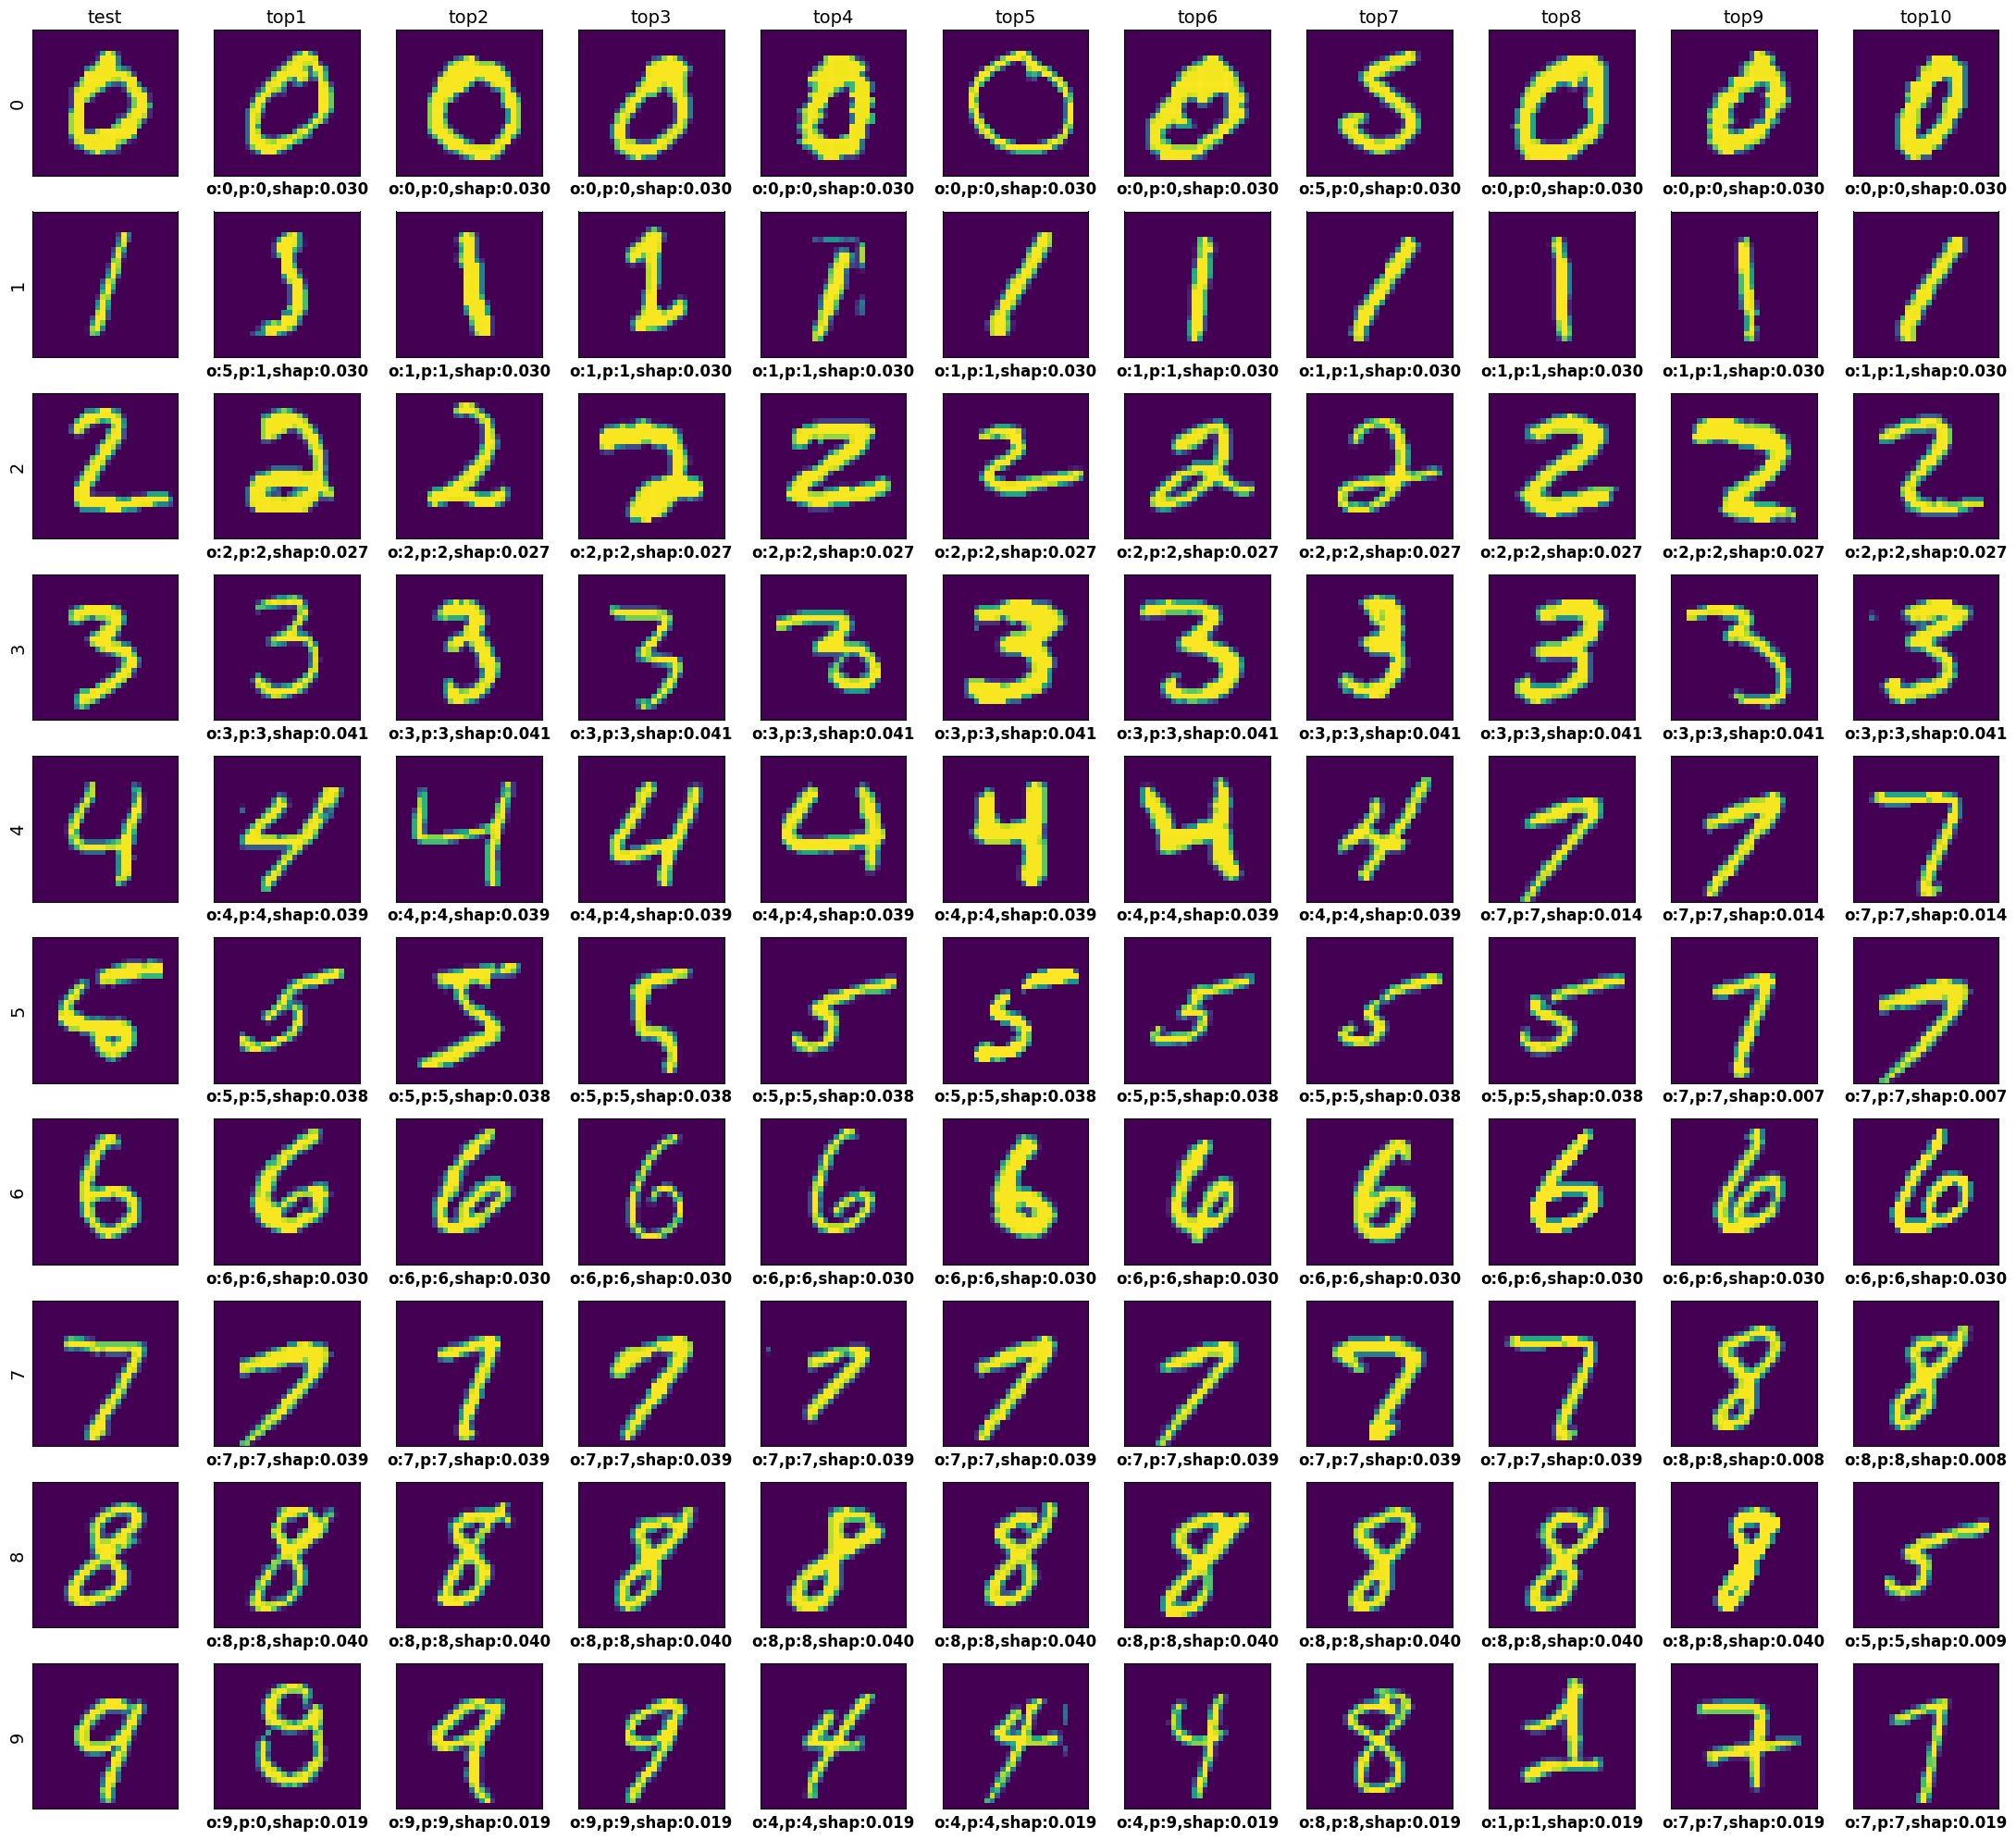

In [3]:
# Select one image from each class
test_x = []
test_x_label = []
shap_test_size = 10
for c in range(10):
    num = 0
    for i in range(len(val_set)):
        if val_set[i][1] == c and torch.max( grand_model(val_set[i][0].resize(1,1,28,28).cuda()), 1 )[1] == c:
            num+=1
            test_x.append(val_set[i][0].numpy())
            test_x_label.append(val_set[i][1])
            if num == shap_test_size//10:
                break
test_x = torch.tensor(test_x)
test_x_label = torch.tensor(test_x_label)

print(test_x.size())
print(test_x_label)

predict_=np.array(predict_)
label_list = []
for predict_label in range(len(set(predict_))):
    label_list.append(np.where(predict_ == predict_label)[0].tolist())
print('groups:',label_list)
# Get explanations
# values = fastshap.shap_values(test_x.cuda(), test_x_label.cuda(), grand_model, null_model)
values = fastshap.shap_values(test_x.cuda(), label_list, grand_model, null_model)

print('pred.shape:', values.shape)
label_values = []
for i in range(10):    
    label_values.append(values[i,:,test_x_label[i]]) 
print(np.array(label_values).shape)
import matplotlib.pyplot as plt
from PIL import Image
num_classes = 10
x = test_x
y = test_x_label
top_k = 10 #取前十个贡献大的训练数据
idxs = []  #存放索引值
train_data_topk = []
train_data_label_topk = []
label_values_topk = []
for i in range(10):
    idxs.append(np.array(label_values[i]).argsort()[::-1][0:top_k])
# print(idxs)
for i in range(len(idxs)): 
    # print(train_data.numpy().shape,train_data_label.numpy().shape) 
    train_data_topk.append(train_data.numpy()[list(idxs[i])])
    train_data_label_topk.append(train_data_label.numpy()[list(idxs[i])])
    label_values_topk.append(label_values[i][list(idxs[i])])

train_data_topk = np.array(train_data_topk)
train_data_label_topk = np.array(train_data_label_topk)
label_values_topk = np.array( label_values_topk)
# print(label_values_topk)
# print(train_data_topk.shape,train_data_label_topk.shape, label_values_topk.shape)
#分别对不同类别的一个样本画出前十最相关的训练图像
fig, axarr = plt.subplots(num_classes, num_classes + 1, figsize=(22, 20))
for row in range(num_classes):
    
    classes_label = ['0','1','2','3','4','5','6','7','8','9']
    classes = [ 'top1', 'top2', 'top3', 'top4', 'top5', 'top6', 'top7', 'top8', 'top9', 'top10']
    mean = np.array([0.5] )[:, np.newaxis, np.newaxis]
    std = np.array([0.5])[:, np.newaxis, np.newaxis]
    im = test_x[row].numpy() * std + mean
    im = im.transpose(1, 2, 0).astype(float)
    im = np.clip(im, a_min=0, a_max=1)
    axarr[row, 0].imshow(im, vmin=0, vmax=1)
    axarr[row, 0].set_xticks([])
    axarr[row, 0].set_yticks([])
    # class labels
    axarr[row, 0].set_ylabel('{}'.format(y[row]), fontsize=14)
    
    # Explanations 
    for col in range(top_k):
        im = train_data_topk[row, col,:,:,:] * std + mean
        im = im.transpose(1, 2, 0).astype(float)
        axarr[row, col + 1].imshow(im, vmin=0, vmax=1)
        axarr[row, col + 1].set_xticks([])
        axarr[row, col + 1].set_yticks([])
        # topk labels
        if row == 0:
            axarr[row, col + 1].set_title('{}'.format(classes[y[col]]), fontsize=14)
            if col == 0:
                axarr[row, col].set_title('test', fontsize=14)
        # shapley values
        # axarr[row, col + 1].set_xlabel('label:{},shap:{:.2f}'.format(train_data_label_topk[row, col],label_values_topk[row, col]), fontsize=12, fontweight='bold')
        axarr[row, col + 1].set_xlabel('o:{},p:{},shap:{:.3f}'.format(train_data_label_topk[row, col],torch.max(grand_model(torch.tensor(train_data_topk[row, col]).resize(1,1,28,28).cuda()), 1 )[1].item(),label_values_topk[row, col]), fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig("exp_fast_datashapley/Visualize_GFDS+_mnist_{}.png".format(train_size))
plt.show()

# Performance

In [4]:
def performance_plots(X, y, vals, link,test_x, y_ture, name=None, 
                        num_plot_markers=20, sources=None):
    """Plots the effect of removing valuable points.
     X:training data
     y:training data label
     y_ture: 当前测试样本真实标签
    Args:
        vals: A list of different valuations of data points each
                in the format of an array in the same length of the data.
        name: Name of the saved plot if not None.
        num_plot_markers: number of points in each plot.
        sources: If values are for sources of data points rather than
                individual points. In the format of an assignment array
                or dict.
                
    Returns:
        Plots showing the change in performance as points are removed
        from most valuable to least.
    """
    plt.rcParams['figure.figsize'] = 8,8
    plt.rcParams['font.size'] = 25
    plt.xlabel('Fraction of training data removed (%)')
    plt.ylabel('Value loss', fontsize=20)
    if not isinstance(vals, list) and not isinstance(vals, tuple):
        vals = [vals]
    if sources is None:
        sources = {i:np.array([i]) for i in range(len(X))}
    elif not isinstance(sources, dict):
        sources = {i:np.where(sources==i)[0] for i in set(sources)}
    vals_sources = [np.array([np.sum(np.array(val)[sources[i]]) 
                                for i in range(len(sources.keys()))])
                for val in vals]
    if len(sources.keys()) < num_plot_markers:
        num_plot_markers = len(sources.keys()) - 1
    plot_points = np.arange(
        0, 
        max(len(sources.keys()) - 10, num_plot_markers),
        max(len(sources.keys())//num_plot_markers, 1)
    )
    # print(plot_points)
    # print(len(vals))
    perfs = [portion_performance( X,y,
        # np.argsort 从小到大的索引值 [::-1]从大到小
        np.argsort(vals_source)[::-1], plot_points,link, test_x, y_ture, sources=sources)
                for vals_source in vals_sources]
    # print(torch.tensor(perfs).shape)
    rnd = np.mean([portion_performance(X,y,
        np.random.permutation(np.argsort(vals_sources[0])[::-1]),
        plot_points,link, test_x, y_ture, sources=sources) for _ in range(1)], 0)
    # print(len(vals))
    # plt.plot(plot_points/len(X) * 100, perfs[0] , 
    #             '-', lw=5, ms=10, color='b')
    
    # plt.plot(plot_points/len(X) * 100, rnd , 
    #             ':', lw=5, ms=10, color='r') 
    # # print("4----------",len(vals))
    # if len(vals)==3:
    #     plt.plot(plot_points/len(X) * 100, perfs[1] , 
    #             '-.', lw=5, ms=10, color='g') 
    #     plt.plot(plot_points/len(X) * 100, perfs[-1], 
    #                 '--', lw=5, ms=10, color='orange')
    #     legends = ['GFDS+', 'Random','DataShapley ', 'LOO']
    # elif len(vals)==2:
    #     legends = ['GFDS+', 'Random','DataShapley ']
    #     plt.plot(plot_points/len(X) * 100, perfs[1] , 
    #             '-.', lw=5, ms=10, color='g') 
    # else:
    #     legends = ['GFDS+', 'Random']   
    # plt.legend(legends)
    # print('ours:',perfs[0])
    # if train_size==100:
    #     print('DataShapley:',perfs[1])
    #     print('loo:',perfs[-1])
    # print('random:',rnd)
    perfs.append(rnd)
    
    # plt.savefig( '{}.png'.format(name),
    #             bbox_inches = 'tight')
    # plt.close()
    # plt.show()
    return perfs
        
def portion_performance(X,y,idxs, plot_points, link,test_x, y_ture, sources=None):
    """Given a set of indexes, starts removing points from 
    the first elemnt and evaluates the new model after
    removing each point."""
    if sources is None:
        sources = {i:np.array([i]) for i in range(len(X))}
    elif not isinstance(sources, dict):
        sources = {i:np.where(sources==i)[0] for i in set(sources)}
    scores = []
    # print("1------------------")
    # print(plot_points)
    for i in range(len(plot_points)):
        keep_idxs = np.concatenate([sources[idx] for idx 
                                    in idxs[plot_points[i]:]], -1)
        # print(keep_idxs,len(keep_idxs))
        origin_idxs = keep_idxs[np.argsort(keep_idxs)]
        # print("-------------",origin_idxs)
        X_batch, y_batch = X[origin_idxs], y[origin_idxs]
        X_S = torch.tensor(X_batch).cuda()
        y_X = torch.tensor(y_batch).cuda()
        class_train_dataset = TensorDataset(X_S,y_X)
        # print(X_S.size(),y_X.size())
        class_train_loader=DataLoader(
            class_train_dataset, batch_size=20, shuffle=True, 
            )
        null_model = torch.load(null_model_path).cuda()
        net = null_model.cuda()
        class_optimizer=torch.optim.Adam(net.parameters(),lr=0.0001)
        loss_function=nn.CrossEntropyLoss()
        # print("2------------------")
        for ep in range(50):
                # 记录把所有数据集训练+测试一遍需要多长时间 
            for img, label in class_train_loader:  # 对于训练集的每一个batch
                # print(img,label)  
                img = img.cuda()
                label = label.cuda()
                out = net( img )  # 送进网络进行输出
                # print(img.size(),label.size())
                loss = loss_function( out, label ) 
                class_optimizer.zero_grad()
                loss.backward()
                class_optimizer.step()
        # print(test_x.view(1,1,28,28).shape)
        # print(net(test_x.view(1,1,28,28).cuda()))
        # print("3------------------",link(net(test_x.view(1,1,28,28).cuda()))[0])
        scores.append(nn.CrossEntropyLoss()(net(test_x.view(1,1,28,28).cuda()),y_ture.view(1).cuda()).item())
    # print(scores)
    return np.array(scores)


/tmp/ipykernel_1184108/2411339381.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_S = torch.tensor(X_batch).cuda()
/tmp/ipykernel_1184108/2411339381.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_X = torch.tensor(y_batch).cuda()


ours: [0.41859118 1.00392477 5.15851834 6.0879612  6.58196962 6.48780093
 6.36854343 6.57052376 6.11960871 6.07917244 5.97498209 6.15053325
 5.5047895  5.56159601 5.73520591 6.14700003 5.73487144 5.80266342]
std: [0.14270893 0.3635651  3.76143854 3.8259893  3.25016762 3.20460614
 3.01824921 2.68488507 2.35557098 2.3451097  2.31408427 1.97118047
 1.74958802 1.89588515 1.59452586 1.48343389 0.30377855 0.34183359]
DataShapley: [0.41957708 0.44403761 0.49548964 0.58514488 0.70953065 0.75461612
 0.81063893 1.03323729 1.19618002 1.32471567 1.4826473  1.69005573
 2.03336018 2.17008331 2.90988497 2.97753163 2.85235006 3.74168541]
std: [0.14479522 0.17003181 0.14917509 0.19348448 0.21816703 0.26189655
 0.32317269 0.34329827 0.41225914 0.53225543 0.64687623 0.56682321
 0.90122089 0.99308148 2.09951295 1.7918942  1.32536482 1.84112792]
loo: [0.41612363 0.44211764 0.50165173 0.66662365 0.74667572 0.77261535
 0.87301196 1.14454731 1.20477077 1.27848179 1.39455859 1.65936049
 1.81435745 1.8704796  1

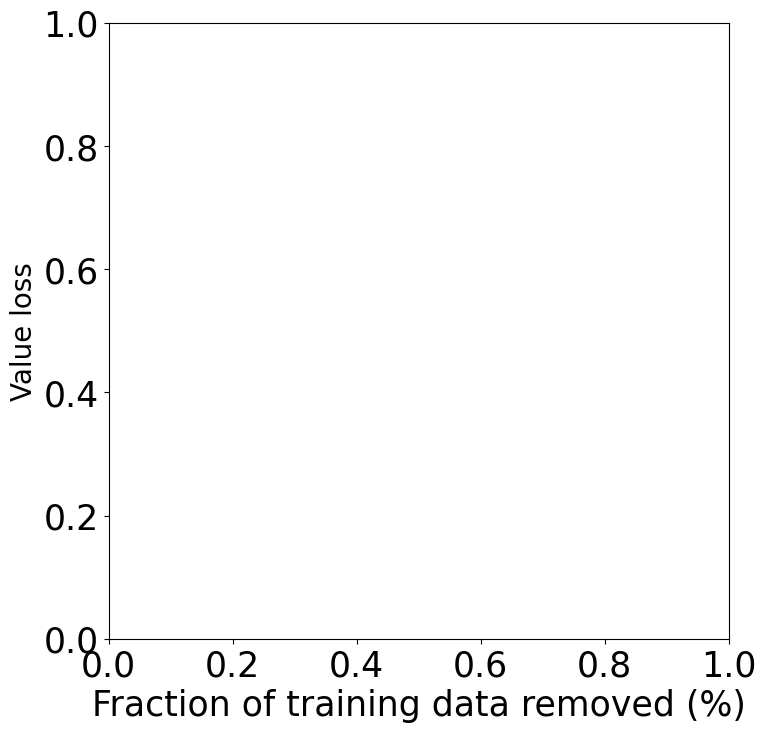

In [5]:
# 测试第i个生成样本
H_eta = []   
for i in range(shap_test_size):
#读取datashapley和loo结果
    if train_size==100:
        tmc = []
        f=open("exp_fast_datashapley/vals_tmc_mnist_{}.txt".format(train_size),"r")
        for line in f:
            tmc.append(float(line.strip('\n')))
        # print(len(tmc),tmc)
        loo = []
        f=open("exp_fast_datashapley/vals_loo_mnist_{}.txt".format(train_size),"r")
        for line in f:
            loo.append(float(line.strip('\n')))
    # print(len(loo),loo)
    # print(len(values[i,:,test_x_label[i]]),values[i,:,test_x_label[i]])
        perfs = performance_plots(train_data,train_data_label,[values[i,:,test_x_label[i]],tmc,loo], nn.Softmax(dim=-1), test_x[i], test_x_label[i], name ="exp_fast_datashapley/GFDS+_mnist__{}_shuffle_compare".format(train_size), num_plot_markers=20)
    else:
        perfs = performance_plots(train_data,train_data_label,[values[i,:,test_x_label[i]]], nn.Softmax(dim=-1), test_x[i], test_x_label[i], name ="exp_fast_datashapley/GFDS+_mnist__{}_shuffle_compare".format(train_size), num_plot_markers=20)
    H_eta.append(perfs)

# plt.show()
H_std = np.std(np.array(H_eta),axis=0)
H_mean = np.mean(np.array(H_eta),axis=0)
print('ours:',H_mean[0])
print('std:',H_std[0])
if train_size==100:
    print('DataShapley:',H_mean[1])
    print('std:',H_std[1])
    print('loo:',H_mean[2])
    print('std:',H_std[2])
print('random:',H_mean[-1])    
print('std:',H_std[-1])


In [6]:
print('ours:',H_mean[0])
if train_size==100:
    print('DataShapley:',H_mean[1])
    print('loo:',H_mean[2])
print('random:',H_mean[-1])

ours: [0.41859118 1.00392477 5.15851834 6.0879612  6.58196962 6.48780093
 6.36854343 6.57052376 6.11960871 6.07917244 5.97498209 6.15053325
 5.5047895  5.56159601 5.73520591 6.14700003 5.73487144 5.80266342]
DataShapley: [0.41957708 0.44403761 0.49548964 0.58514488 0.70953065 0.75461612
 0.81063893 1.03323729 1.19618002 1.32471567 1.4826473  1.69005573
 2.03336018 2.17008331 2.90988497 2.97753163 2.85235006 3.74168541]
loo: [0.41612363 0.44211764 0.50165173 0.66662365 0.74667572 0.77261535
 0.87301196 1.14454731 1.20477077 1.27848179 1.39455859 1.65936049
 1.81435745 1.8704796  1.90014252 2.0312051  2.42851119 2.73440119]
random: [0.39794149 0.44441832 0.47336521 0.60615958 0.76141804 0.81946607
 0.87422734 1.07849041 1.2409458  1.37407697 1.4732152  1.66618472
 1.86910908 1.99145286 2.04404607 2.21675349 2.7902571  2.85559398]


: 